In [27]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import animation # animations

import networkx as nx
from datetime import datetime
from operator import itemgetter
import itertools
import powerlaw
import collections

Note:

- The trade data are given in millions of 
	current year US dollars
- The population figures are in 1000s
- The real GDP per capita figures are real figures 
	in constant US dollars (base 1996)

Labels:
- acra/b		Three letter acronym for state A/B	
- numa/b		Numeric id code for state A/B
- year		Year
- expab		Export A to B
- eabo		Export A to B origin code
- impab		Import A from B
- iabo		Import A from B origin code
- expba		Export B to A 		
- ebao		Export B to A origin code
- impba		Import B from A 
- ibao		Import B from A origin code
- popa		Population of A
- rgdpca/b	Real GDP per capita of A/B
- cgdpca/b	Current GDP per capita of A/B
- goa/b		Origin of GDP per capita estimate A/B
- tottra/b	Total trade for country A/B


In [2]:
df_raw = pd.read_csv('trade_udd.asc', sep=' ')
df_raw

,acra,numa,acrb,numb,year,expab,eabo,impab,iabo,expba,ebao,impba,ibao
0,USA,2,CAN,20,1948,1946.0,0.0,1794.0,0.0,1568.0,0.0,1853.0,1.0
1,USA,2,CAN,20,1949,1959.0,0.0,1743.0,0.0,1475.0,0.0,1910.0,1.0
2,USA,2,CAN,20,1950,2025.0,0.0,2101.0,0.0,1877.0,0.0,1966.0,1.0
3,USA,2,CAN,20,1951,2674.0,0.0,2466.0,0.0,3668.0,0.0,2674.0,1.0
4,USA,2,CAN,20,1952,2976.0,0.0,2601.0,0.0,2418.0,0.0,3049.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
579224,PAL,986,FSM,987,1996,0.0,6.0,0.0,6.0,0.0,6.0,0.0,6.0
579225,PAL,986,FSM,987,1997,0.0,6.0,0.0,6.0,0.0,6.0,0.0,6.0
579226,PAL,986,FSM,987,1998,0.0,6.0,0.0,6.0,0.0,6.0,0.0,6.0
579227,PAL,986,FSM,987,1999,0.0,6.0,0.0,6.0,0.0,6.0,0.0,6.0


In [6]:
# Functions creating dfs for each year 1948-2000

def preprocess_data(df_raw):
    df = df_raw.drop(['numa','numb'], axis=1)
    # Mean from reported export and import
    df['expab'] = (df['expab'] + df['impba'] )/2
    df['expba'] = (df['expba'] + df['impab'] )/2
    
    # Drop columns
    df = df.drop(['eabo','iabo','ebao','ibao','impab','impba'], axis=1)

    # delete non-reciprocal trading partners
    df = df[(df['expab'] != 0) & (df['expba'] != 0)]
    return df

def scale_prices(df):
    inflation = pd.read_csv('CPIAUCNS.csv')
    inflation['CPI_Multiplier'] = inflation['CPI'].iloc[-1] / inflation['CPI'] 
    df = pd.merge(df,inflation,how = 'left',on = 'year')
    df['expab'] = df['expab'] * df['CPI_Multiplier']
    df['expba'] = df['expba'] * df['CPI_Multiplier']
    df = df.drop(['CPI','CPI_Multiplier'],axis=1)
    return df
    
def dfs_trade_together(df_raw, infl=False):

    # Preprocess data
    df = preprocess_data(df_raw)
    
    # Year's list
    years = list(df['year'].drop_duplicates())
    
    # scale prices to USD from 2021
    if(infl):
        df = scale_prices(df)

    # split years
    dfs = []
    for year in years:
        dfs.append(df[df['year'] == year])
        
    return dfs, years

# For directed graph (two-way trade)
def dfs_trade_directed(df_raw, infl=False):
    # Preprocess data
    df2 = preprocess_data(df_raw)

    # trade B to A
    df3 = df2.copy(deep=True)
    df3['weight'] = df3['expba']
    df3 = df3.rename(columns={'acra':'acrb','acrb':'acra'})
    df3 = df3.drop(['expab','expba'], axis=1)

    # trade A to B
    df2['weight'] = df2['expab']
    # df2 = df2.drop(['expab','expba'], axis=1)
    
    # Concatenate
    df = pd.concat([df2,df3])
    
    # Year's list
    years = list(df['year'].drop_duplicates())

     # scale prices to USD from 2021
    if(infl):
        df = scale_prices(df)
    
    # split years
    dfs = []
    for year in years:
        dfs.append(df[df['year'] == year])
        
    return dfs, years

# For undirected graph (sum of trade)    
def dfs_trade_undirected(df_raw, infl=False):
    # Preprocess data
    df = preprocess_data(df_raw)

    # Sum trade
    df['weight'] = df['expab'] + df['expba']
    # df = df.drop(['expab','expba'], axis=1)
    
    # Year's list
    years = list(df['year'].drop_duplicates())
    
    # scale prices to USD from 2021
    if(infl):
        df = scale_prices(df)
    
    # split years
    dfs = []
    for year in years:
        dfs.append(df[df['year'] == year])
        
    return dfs, years
    

In [28]:
# Plot Powerlaw CCDF
def plot_powerlaw(dane, xlabel, title):
    fit = powerlaw.Fit(dane, xmin=min(dane))
      
    fig = plt.figure(figsize=(10,8))
    font = {'family':'normal','size': 15}
    matplotlib.rc('font', **font)
    
    fig = powerlaw.plot_ccdf(dane, color='b',marker='o',linestyle='');
    
    fit.power_law.plot_ccdf(color='blue', linestyle='--',lw=2, ax=fig,label='PL')
    fit.lognormal.plot_ccdf(color='tab:red', linestyle='--', lw=2, ax=fig,label='LN')
    fit.exponential.plot_ccdf(color='tab:orange', linestyle='--',lw=2, ax=fig,label='EXP')
    fit.truncated_power_law.plot_ccdf(color='tab:green', linestyle='--',lw=2, ax=fig,label='CUTOFF')
    fit.stretched_exponential.plot_ccdf(color='tab:purple', linestyle='--',lw=2, ax=fig,label='STR.EXP')  
    
    # ylim estimated from EDA
    yup = 2
    ydown = 1/(len(dane)+2)
    plt.ylim(ydown,yup)
    
    plt.legend(loc=3)
    plt.ylabel(r'P(X$\geq$x)')
    plt.xlabel(xlabel)
    plt.title(title)
    plt.grid(True, which="major",color='#5C5353')

# Plot stack plots     
def my_stack_plot(dfs, Ntop, what, years, title):
    
    topdicts = []

    for i,year in enumerate(years):
        df = dfs[i]
        # create directed graph
        G = nx.from_pandas_edgelist(
        df,
        source='acra',
        target='acrb',
        edge_attr='weight',
        create_using=nx.DiGraph()
    )
        if(what=='all'):
            A = dict(G.degree(weight='weight')) # sum of trade
        elif(what=='exp'):
            A = dict(G.out_degree(weight='weight')) # export
        elif(what=='imp'):
            A = dict(G.in_degree(weight='weight')) # import
            
        top = dict(sorted(A.items(), key = itemgetter(1), reverse = True)[:Ntop]) # top 10
        sumA = sum(A.values()) #sum all
        sumTop = sum(top.values()) # sum top 10

        # Other than top 10
        top['Others'] = sumA - sumTop
        # normalize
        top = {k: v / sum(top.values()) for k, v in top.items()} 
        topdicts.append(top)
        
    # list top countries
    all_keys = list(set().union(*(d.keys() for d in topdicts)))
    all_keys.remove('Others') 
    all_keys.append('Others') 

    dd = collections.defaultdict(list)

    # exclude countires that drop off from top 10 within
    for d in topdicts:
        loosers = [x for x in all_keys  if x not in list(d.keys())] 
        
        for k in loosers:
            dd[k].append(0)
              
        for k, v in d.items():
            dd[k].append(v)   

    #Plot
    fig, ax = plt.subplots(figsize=(14,8))
    ax.stackplot(years, dd.values(),labels=dd.keys(), alpha=0.8)
    
    ax.set_title(title)
    ax.set_xlabel("Year")
    ax.set_ylabel("Share of global trade")

    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], title=f'Top {Ntop} Countries', loc='center left', bbox_to_anchor=(1, 0.5))

## Prepare data

In [8]:
direct_dfs, years = dfs_trade_directed(df_raw)
undirect_dfs, years = dfs_trade_undirected(df_raw)

# adjusted to inflation based on Consumer Price Index for All Urban Consumers 2021
direct_dfs_infl, years = dfs_trade_directed(df_raw, infl=True)
undirect_dfs_infl, years = dfs_trade_undirected(df_raw, infl=True)

## Powerlaw plots for each year = scale of world trade

In [12]:
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

In [14]:
path = 'plots_infl_thr100/'
thr = 100

for i,year in enumerate(years):
    df = direct_dfs_infl[i]
    G = nx.from_pandas_edgelist(
    df,
    source='acra',
    target='acrb',
    edge_attr='weight',
    create_using=nx.DiGraph()
)
    
    # delete edges with less than threshold
    rem_list = []
    for i,j,k in G.edges(data=True):
        if(list(k.values())[0] < thr):
            rem_list.append((i,j)) 
    G.remove_edges_from(rem_list) 
    G.remove_nodes_from(list(nx.isolates(G))) # delte isolated nodes    
    
    # extract values
    k = list(dict(G.degree()).values()) # node degree = "diplomats"
    s = list(dict(G.degree(weight='weight')).values()) # node strength = "traders"
    
    sin = list(dict(G.in_degree(weight='weight')).values()) # node incoming strength = "importers"
    sout = list(dict(G.out_degree(weight='weight')).values()) # node outgoing strength = "exporters"
    
    w = [list(l.values()) for i,j,l in G.edges(data=True)]
    w = list(itertools.chain.from_iterable(w)) # edges weights = trade flow
    
    # plots
    plot_powerlaw(k,'Degree k',f'CCDF of number of trade partners in year: {year}')
    plt.savefig(f'{path}k{year}.png', bbox_inches='tight')
    plt.close()
    
    plot_powerlaw(s,'Strength s, [mil$2021]',f'CCDF of trade sum in year: {year}')
    plt.savefig(f'{path}/s{year}.png', bbox_inches='tight')
    plt.close()
    
    plot_powerlaw(s,'Strength s of imports [mil$2021]',f'CCDF of imports sum in year: {year}')
    plt.savefig(f'{path}/s_imp{year}.png', bbox_inches='tight')
    plt.close()
    
    plot_powerlaw(s,'Strength s of exports [mil$2021]',f'CCDF of exports sum in year: {year}')
    plt.savefig(f'{path}/s_exp{year}.png', bbox_inches='tight')
    plt.close()
    
    plot_powerlaw(s,'Weights of edges [mil$2021]',f'CCDF of trade flow in year: {year}')
    plt.savefig(f'{path}/w{year}.png', bbox_inches='tight')
    plt.close()

## Assortativity = preference to trade with simmilar countries

In [15]:
r_list = []
r_labels = []

for i,year in enumerate(years):
    df = undirect_dfs_infl[i]
    G = nx.from_pandas_edgelist(
    df,
    source='acra',
    target='acrb',
    edge_attr='weight',
    create_using=nx.Graph()
)

    # set thresholds for minimal trade flow
    thresh = np.logspace(0,2,5) 
    thresh = np.insert(thresh,0 , 0) # 0 for sanity check
    reciprocity_year = []
    
    for t in thresh:
        rem_list = []
        for i,j,k in G.edges(data=True):
            if(list(k.values())[0] < t):
                rem_list.append((i,j)) 
        G.remove_edges_from(rem_list) 
        G.remove_nodes_from(list(nx.isolates(G))) 
    
        r_list.append(nx.degree_pearson_correlation_coefficient(G, weight='weight'))

# swap axes
flat_list = r_list #[x for xs in r_list for x in xs]
r_list = []
for i in range(len(thresh)):
    #print(flat_list[i::len(thresh)])
    r_list.append(flat_list[i::len(thresh)])

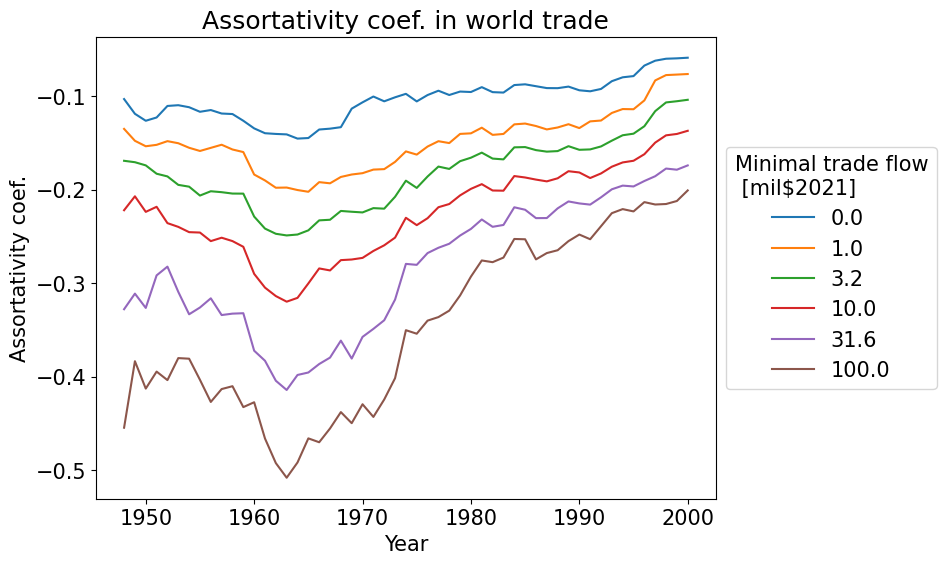

In [16]:
# Plot 
fig, ax = plt.subplots(figsize=(10,6))

for i, r in enumerate(r_list):
    ax.plot(years,r, label=f'{thresh[i]:.1f}')
#plt.legend()
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.set_title("Assortativity coef. in world trade")
ax.set_xlabel("Year")
ax.set_ylabel("Assortativity coef.")

# Put a legend to the right of the current axis
handles, labels = ax.get_legend_handles_labels()
ax.legend(title=f'Minimal trade flow\n [mil$2021]', loc='center left', bbox_to_anchor=(1, 0.5))

fig.savefig(f'r_pearson.png', bbox_inches='tight')

## Rich club = cluster of trading most

In [17]:
def rich_club_plot(i):
    
    rc_list = []
    
    df = undirect_dfs_infl[i]
    G = nx.from_pandas_edgelist(
    df,
    source='acra',
    target='acrb',
    edge_attr='weight',
    create_using=nx.Graph()
)

    thresh = np.logspace(0,2,5) 
    thresh = np.insert(thresh,0 , 0)
    
    for t in thresh:
        rem_list = []
        for i,j,k in G.edges(data=True):
            if(list(k.values())[0] < t):
                rem_list.append((i,j)) 
        G.remove_edges_from(rem_list) 
        G.remove_nodes_from(list(nx.isolates(G)))
    
        rc_list.append(nx.rich_club_coefficient(G, normalized=False))
    return rc_list

In [18]:
year = 2000
n = year - 1948
rc_list = rich_club_plot(n)

k =  []
krc =[]

for dic in rc_list:
    k.append(list(dic.keys()))
    krc.append(list(dic.values()))

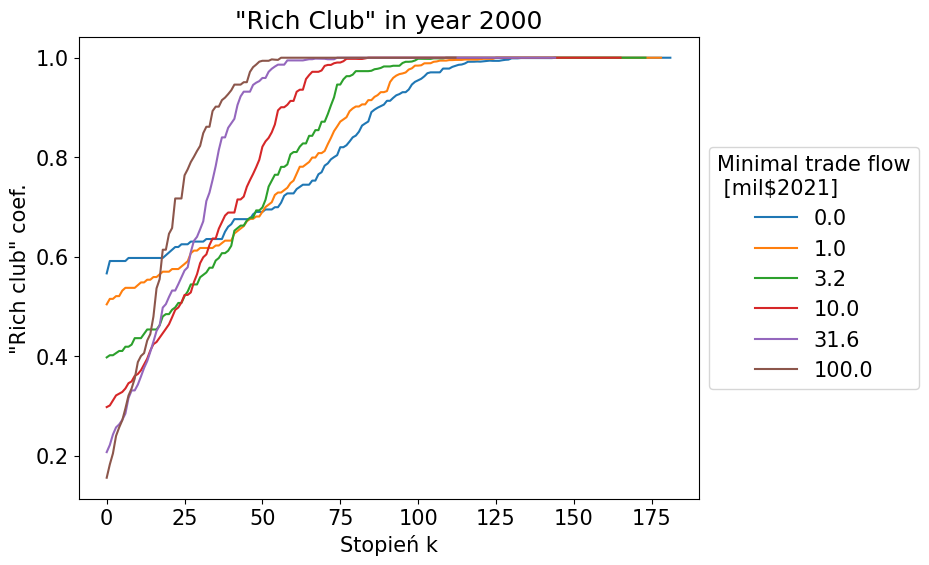

In [19]:
fig, ax = plt.subplots(figsize=(10,6))

for i, r in enumerate(k):
    ax.plot(k[i],krc[i], label=f'{thresh[i]:.1f}')
#plt.legend()
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.set_title(f'"Rich Club" in year {years[n]}')
ax.set_xlabel("Stopień k")
ax.set_ylabel(f'"Rich club" coef.')

# Put a legend to the right of the current axis
handles, labels = ax.get_legend_handles_labels()
ax.legend(title=f'Minimal trade flow\n [mil$2021]', loc='center left', bbox_to_anchor=(1, 0.5))

fig.savefig(f'richclub_{years[n]}.png', bbox_inches='tight')

## Reciprocity

In [20]:
reciprocity = []

for i,year in enumerate(years):

    df = direct_dfs_infl[i]
    G = nx.from_pandas_edgelist(
    df,
    source='acra',
    target='acrb',
    edge_attr='weight',
    create_using=nx.DiGraph()
)
    thresh = np.logspace(0,2,5) 
    thresh = np.insert(thresh,0 , 0) 
    reciprocity_year = []
    
    for t in thresh:
    
        rem_list = []

        for i,j,k in G.edges(data=True):
            if(list(k.values())[0] < t):
                rem_list.append((i,j)) 
        G.remove_edges_from(rem_list) 
        
        reciprocity_year.append(nx.reciprocity(G))
    reciprocity.append(reciprocity_year)
    
flat_list = [x for xs in reciprocity for x in xs]
reciprocity = []
for i in range(len(thresh)):
    #print(flat_list[i::len(thresh)])
    reciprocity.append(flat_list[i::len(thresh)])

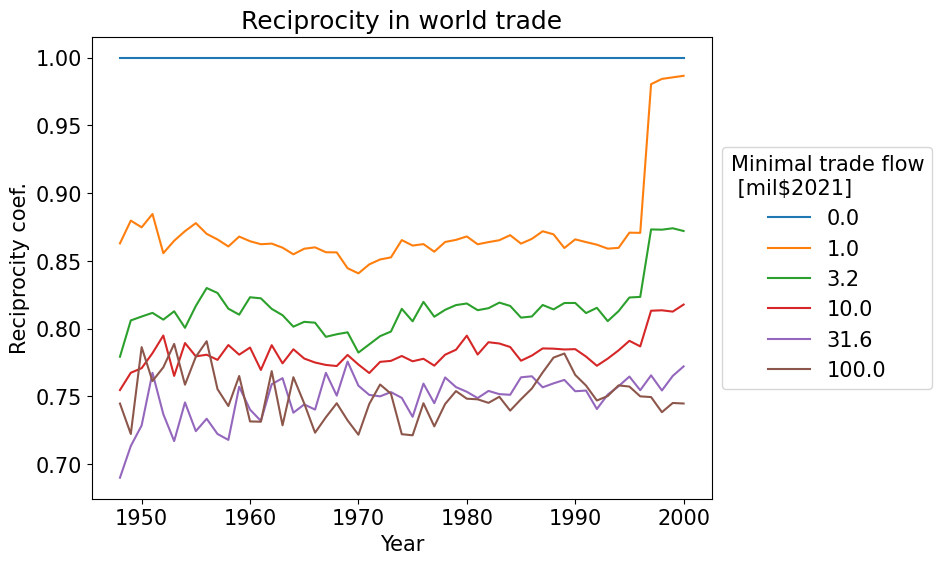

In [21]:
fig, ax = plt.subplots(figsize=(10,6))

for i, r in enumerate(reciprocity):
    ax.plot(years,r, label=f'{thresh[i]:.1f}')
#plt.legend()
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.set_title("Reciprocity in world trade")
ax.set_xlabel("Year")
ax.set_ylabel("Reciprocity coef.")

# Put a legend to the right of the current axis
handles, labels = ax.get_legend_handles_labels()
ax.legend(title=f'Minimal trade flow\n [mil$2021]', loc='center left', bbox_to_anchor=(1, 0.5))

fig.savefig(f'reciprocity.png', bbox_inches='tight')

## Stackplots

In [38]:
Ntop = 8 # number of top
my_stack_plot(direct_dfs_infl,Ntop, 'all', years,'Top countries by trade value')

plt.savefig(f'plots_infl/alltrade5.png', bbox_inches='tight')
plt.close()

In [39]:
my_stack_plot(direct_dfs_infl,Ntop, 'imp', years,'Top countries by import value')
plt.savefig(f'plots_infl/allimport5.png', bbox_inches='tight')
plt.close()

In [40]:
my_stack_plot(direct_dfs_infl,Ntop, 'exp', years,'Top countries by export value')
plt.savefig(f'plots_infl/allexport5.png', bbox_inches='tight')
plt.close()

## Animations

In [34]:
# together_dfs, years = dfs_trade_together(df_raw, infl=True)
# delta_w_list = []

# for i,year in enumerate(years):
    
#     #wybieramy df
#     df = together_dfs[i]
    
#     #wartości bez 0
#     delta_w = list(np.abs(df['expab']-df['expba']))
#     delta_w = [x for x in delta_w if x > 0.01]
    
#     plot_powerlaw(delta_w,r'\Delta w',f'CCDF bilansu handlowego w roku {year}')
#     plt.savefig(f'plots_delta_w\delta_w_{year}.png', bbox_inches='tight')
#     plt.close()
    
#     #dodajemy do listy która pójdzie do animacji
#     delta_w_list.append(delta_w)

# k_list = []
# s_list = []
# sin_list = []
# sout_list = []
# w_list = []

# for i,year in enumerate(years):
#     #wybieramy df
#     df = direct_dfs_infl[i]
#     # tworzymy directed graph
#     G = nx.from_pandas_edgelist(
#     df,
#     source='acra',
#     target='acrb',
#     edge_attr='weight',
#     create_using=nx.DiGraph()
# )
    
#     # jeżeli cchesz możesz usunąć mikrokrawędzie np. waga mniejsza niż 100.000 mln
#     thr = 100
#     rem_list = []
#     for i,j,k in G.edges(data=True):
#         if(list(k.values())[0] < thr):
#             rem_list.append((i,j)) 
#     G.remove_edges_from(rem_list) # usuwamy mikrokrawędzie
#     G.remove_nodes_from(list(nx.isolates(G))) # usuwamy odizolowane węzły
    
    
#     # obliczamy zbiory?
#     k = list(dict(G.degree()).values()) # dyplomaci
#     s = list(dict(G.degree(weight='weight')).values()) # handlarze
    
#     sin = list(dict(G.in_degree(weight='weight')).values()) # importerzy
#     sout = list(dict(G.out_degree(weight='weight')).values()) # ekxporterzy
    
#     w = [list(l.values()) for i,j,l in G.edges(data=True)]
#     w = list(itertools.chain.from_iterable(w)) # posiadacze kontenerowcy...
    
#     # jakieś 0 mogą być, nie wiem czemu
#     sin = [x for x in sin if x > 0.01]
#     sout = [x for x in sout if x > 0.01]
#     w = [x for x in w if x > 0.01]
#     #dodajemy do list
#     k_list.append(k)
#     s_list.append(s)
#     sin_list.append(sin)
#     sout_list.append(sout)
#     w_list.append(w)

In [39]:
# def simple_update(num, states, ax):
#     ax.clear()

#     #nx.draw(G, pos=layout, node_color=states[num], ax=ax, cmap=plt.cm.Set1, with_labels=True)
#     dane = states[num]
    
#     fit = powerlaw.Fit(dane, xmin=min(dane))
#     ax = powerlaw.plot_ccdf(dane, color='b',marker='o',linestyle='');
    
#     fit.power_law.plot_ccdf(color='blue', linestyle='--',lw=2, ax=ax, label='PL')
#     fit.lognormal.plot_ccdf(color='tab:red', linestyle='--', lw=2, ax=ax, label='LN')
#     fit.exponential.plot_ccdf(color='tab:orange', linestyle='--',lw=2, ax=ax, label='EXP')
#     fit.truncated_power_law.plot_ccdf(color='tab:green', linestyle='--',lw=2, ax=ax, label='CUTOFF')
#     fit.stretched_exponential.plot_ccdf(color='tab:purple', linestyle='--',lw=2, ax=ax, label='STR.EXP') 
    
#     # Set the title
#     ax.set_title(f"CCDF wag krawędzi w roku {years[num]}")
    
#     # ylim
#     yup = 2
#     ydown = 1/(len(dane)+2)
#     ax.set_ylim(ydown,yup)
    
#     ax.legend(loc=3)
#     ax.set_ylabel(r'P(X $\geq$ x)')
#     ax.set_xlabel("Wagi krawędzi w [mln$2021]")
#     ax.grid(True, which="major",color='#5C5353')

# def simple_animation(lista_wartosci, title=f'w_animation_{datetime.now().strftime("%Y_%m_%d_%H%M%S")}.gif'):

#     # Build plot
#     fig, ax = plt.subplots(figsize=(8,6))

#     ani = animation.FuncAnimation(fig, simple_update, interval=300, frames=len(lista_wartosci), fargs=(lista_wartosci, ax));
#     ani.save(title, writer='imagemagick');
#     #plt.show()
# simple_animation(w_list)